## ImageBasedDataMiningContinuous.ipynb
‹ ImageBasedDataMining.ipynb › Copyright (C) ‹ 2019 › ‹ Andrew Green - andrew.green-2@manchester.ac.uk › This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

In [1]:
"""
| date      | who     | note                                                  |
|----------|----------|-------------------------------------------------------|
| 20190201 |    afg   |  First version, adapted from MadagaSKA code           |
| 20190208 |    afg   |  Updated code, completed up to point of plotting      |
| 20190208 |    afg   |  Update paths in code to work with docker container   |
""";

This notebook shows how to do image based data mining against a continuous outcome. The outcome could be whatever you like, provided it is a continuous variable; some examples include weight loss, muscle area loss and feeding tube duration

In [30]:
## Import libraries and set up

import os
import time
import os.path
import numpy as np
try:
    from tqdm import tqdm_notebook as tqdm
    haveTQDM = True
except:
    haveTQDM = False
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline

## Make the notebook use full width of display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [32]:
%%javascript
// this cell stops the notebook from putting outut in scrolling frames, which I find really annoying
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

Once again, we will use pandas to load the csv. The next cell contains all the pre-processing from the binary data mining, in a single cell, including the check that a dose distribution is available for each patient. By the end of the cell, we should have a set of clean data again.

In [4]:
import pandas as pd

clinicalDataPath = "/data/clinicalData.csv"

clinicalData = pd.read_csv(clinicalDataPath)

ccrtOnlyPatients = clinicalData[(clinicalData["Oncologic Treatment Summary"].str.contains('^CCRT', regex=True)) & (clinicalData["Oncologic Treatment Summary"].str.contains('\+', regex=True) == False)]
len(ccrtOnlyPatients["Oncologic Treatment Summary"])

selectedPatients = ccrtOnlyPatients[ccrtOnlyPatients["Number of Fractions"].astype(int) < 40]
len(selectedPatients["Number of Fractions"])

def calculateBEDCorrection(df, early=True):
    earlyAlphaBeta = 10.0
    lateAlphaBeta  = 03.0
    if early:
        df = df.assign(BEDfactor = lambda d : 1.0 + d["Dose/Fraction (Gy/fx)"].astype(float)/earlyAlphaBeta)
    else:
        df = df.assign(BEDfactor = lambda d : 1.0 + d["Dose/Fraction (Gy/fx)"].astype(float)/lateAlphaBeta)
    return df

selectedPatients = calculateBEDCorrection(selectedPatients)

dosesPath = "/data/registeredDoses"
availableDoses = ["HNSCC-01-{0}".format(a.split('.')[0]) for a in os.listdir(dosesPath)]

availablePatientsMask = selectedPatients['ID'].isin(availableDoses)
probeDose = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0:04d}.nii".format(int(2)))))

selectedPatients = selectedPatients.loc[availablePatientsMask]


Now we have our BED correction, we can start loading data ready to do mining. We will load each image using SimpleITK, convert it to a numpy array and put it into a bit numpy array. We will concurrently load the binary status from the clinical data as well and put that into a numpy array.

In the next cell, we will load all our data. Note that we pre-allocate the numpy array we will use to hold the data - this is a performance optimisation to make loading the data a bit quicker.

In [5]:
probeDose = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0:04d}.nii".format(int(2)))))

doseArray = np.zeros((*probeDose.shape, len(selectedPatients)))
statusArray = np.zeros((len(selectedPatients),1))

n = 0
for idx, pt in selectedPatients.iterrows():
    doseArray[...,n] = pt.BEDfactor * sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0}.nii".format(pt.ID.split("-")[-1]))))
    n += 1

(123, 128, 128)
(123, 128, 128, 48)


Now we have our data, and we have corrected all the doses tot eh same BED, we are ready to do continuous outcome image based data mining.

For this we need to select a suitable outcome variable - I suggest weight loss as a good one to start with. 

The next cell defines a function that calculates the pearson correlation coefficient in each voxel of the dose distribution. To do this, we slightly modify the online calculation of variance used in the binary data mining to do online calculation of covariance. The formula for pearson's correlation coefficient is then:

$ \rho = \frac{cov(X,Y)}{\sigma_{x} \sigma_{y}} $


(note: strictly, this is for a population, but the estimates for variance and covariance we return are for a sample, so it will work)


In [58]:
def imagesCorrelation(doseData, continuousOutcome, mask=None):
    """
    Calculate a per-voxel correlation coefficient between two images. Uses Welford's method to calculate mean, variance and covariance. 
    
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - statuses: the outcome labels. 1 indicates an event, 0 indicates no event
    Returns:
        - rhoValues: an array of the same size as one of the images which contains the per-voxel rho values
    """
    doseMean = np.zeros_like(doseData[...,0])
    doseStd = np.zeros_like(doseData[...,0])
    covariance = np.zeros_like(doseData[...,0])
    C = np.zeros_like(doseData[...,0])
    rho = np.zeros_like(doseData[...,0])
    
    
    outcomeMean = 0.0
    outcomeVar = 0.0
    doseMean[np.where(mask)] += doseData[...,0][np.where(mask)]
    outcomeMean += continuousOutcome[0]
    subjectCount = 1.0
    
    for n,y in zip(range(1, doseData.shape[-1]), continuousOutcome[1:]):
        x = doseData[...,n]
        subjectCount += 1.0
        dx = x - doseMean
        
        om = doseMean.copy()
        yom = outcomeMean.copy()

        doseMean[np.where(mask)] += dx[np.where(mask)]/subjectCount
        outcomeMean += (y - outcomeMean)/subjectCount

        doseStd[np.where(mask)] += ((x[np.where(mask)] - om[np.where(mask)])*(x[np.where(mask)] - doseMean[np.where(mask)]))
        outcomeVar += (y - yom)*(y - outcomeMean)

        C[np.where(mask)] += (dx[np.where(mask)] * (y - outcomeMean))
        
    doseStd[np.where(mask)] /= (subjectCount)
    outcomeVar /= (subjectCount)
    covariance[np.where(mask)] = C[np.where(mask)] / (subjectCount - 1) ## Bessel's correction for a sample

    rho[np.where(mask)] = covariance[np.where(mask)] / (np.sqrt(doseStd[np.where(mask)]) * np.sqrt(outcomeVar))
#     if mask is not None:
#         rho *= mask.astype(np.float64)
    return rho

This function is very similar to the one we used in the binary IBDM code, but this time it also calculates the covariance between dose in each voxel and the continuous outcome variable. We then use that covariance to calculate the correlation between dose and outcome.

Now we can apply the mining to some data.  The first thing we need to do is select a continuous outcome variable; we will try weight loss first - we need to create this variable from our database in the same way we did for the BEDfactor earlier.

In [61]:
probeDose = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0:04d}.nii".format(int(2)))))
doseArray = np.zeros((*probeDose.shape, len(selectedPatients)))
n = 0
for idx, pt in selectedPatients.iterrows():
    doseArray[...,n] = pt.BEDfactor * sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0}.nii".format(pt.ID.split("-")[-1]))))
    n += 1
    
selectedPatients = selectedPatients.assign(WeightLoss = lambda d : d["WeightStop"] - d["WeightStart"])
weightLoss = selectedPatients.WeightLoss.values   


In [62]:
mask = sitk.GetArrayFromImage(sitk.ReadImage("/data/0002_mask_ds.nii")).astype(np.int16)

rhoMap = imagesCorrelation(doseArray, weightLoss, mask=mask)

referenceAnatomy = sitk.GetArrayFromImage(sitk.ReadImage("/data/downsampledCTs/0002.nii"))

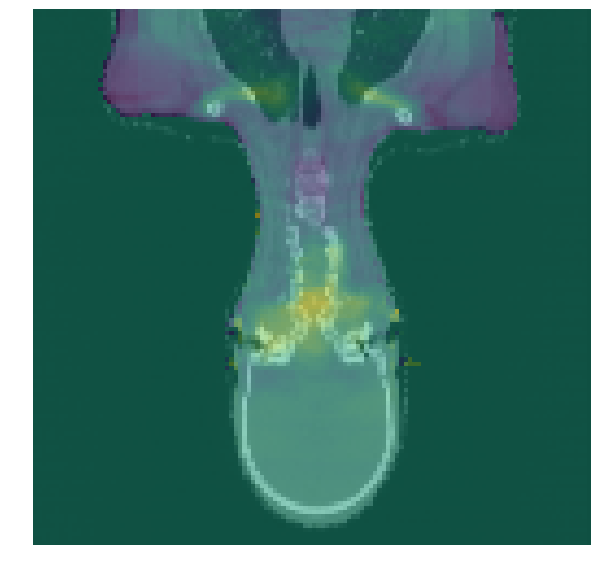

In [63]:
fig = plt.figure(figsize=(10,10))
anatomy = plt.imshow(referenceAnatomy[:,64,...], cmap='Greys_r')
rhoMapOverlay = plt.imshow(rhoMap[:,64,...], alpha=0.5)
_ = plt.axis('off')

Now we've got our correlation map with the true correspondence of weight loss to dose, we can compute the permutation distribution again to get the significance of the correlation.

This works just like before, we just rearrange the weight loss values and re-calculate the correlation coefficient and look at how the most extreme voxels behave

In [84]:
def doPermutation(doseData, outcome, mask=None):
    """
    Permute the statuses and return the maximum t value for this permutation
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - outcome: the outcome values. Shuold be a continuous number. These will be permuted in this function to 
                    assess the null hypothesis of no dose interaction
        - mask: A mask outside which we will ignore the returned correlation
    Returns:
        - (tMin, tMax): the extreme values of the whole t-value map for this permutation
    """
    poutcome = np.random.permutation(outcome)
    permT = imagesCorrelation(doseData, poutcome, mask)
    return (np.min(permT), np.max(permT))


def permutationTest(doseData, outcome, nperm=1000, mask=None):
    """
    Perform a permutation test to get the global p-value and t-thresholds
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - outcome: the outcome labels. Should be a continuous number.
        - nperm: The number of permutations to calculate. Defaults to 1000 which is the minimum for reasonable accuracy
        - mask: A mask outside which we will ignore the returned correlation
    Returns:
        - globalPNeg: the global significance of the test for negative t-values
        - globalPPos: the global significance of the test for positive t-values
        - tThreshNeg: the list of minT from all the permutations, use it to set a significance threshold.
        - tThreshPos: the list of maxT from all the permutations, use it to set a significance threshold.
    """
    tthresh = []
    gtCount = 1
    ltCount = 1
    trueT = imagesCorrelation(doseData, outcome, mask=mask)
    trueMaxT = np.max(trueT)
    trueMinT = np.min(trueT)
    if haveTQDM:
        for perm in tqdm(range(nperm)):
            tthresh.append(doPermutation(doseData, outcome, mask))
            if tthresh[-1][1] > trueMaxT:
                gtCount += 1.0
            if tthresh[-1][0] < trueMinT:
                ltCount += 1.0
    else:
        for perm in range(nperm):
            tthresh.append(doPermutation(doseData, outcome, mask))
            if tthresh[-1][1] > trueMaxT:
                gtCount += 1.0
            if tthresh[-1][0] < trueMinT:
                ltCount += 1.0
    
    globalpPos = gtCount / float(nperm)
    globalpNeg = ltCount / float(nperm)
    tthresh = np.array(tthresh)
    return (globalpNeg, globalpPos, sorted(tthresh[:,0]), sorted(tthresh[:,1]))

If we run this function with our data, we will get back the global significance and threshold values of $\rho$. We can then use a contour plot at the 95th percentile to indicate regions of significance.

Let's try doing it now - this is once again equivalent to the binary data mining, but with the continuous data mining code we wrote above. The function call is identical to the binary version, but because the content of the functions is different, it is now doing the calculation with continuous IBDM.

*Warning: this cell will take a really long time to run! On my machine, it was about 13 minutes*

In [85]:
pNeg, pPos, threshNeg, threshPos = permutationTest(doseArray, weightLoss, nperm=100, mask=mask)

In [86]:
print(pNeg, pPos)
print(np.percentile(threshNeg, 10))
print(threshNeg)
print(np.min(rhoMap))

print(threshPos)
print(np.max(rhoMap))

0.01 0.85
-0.5678511904799166
[-0.6219988997229952, -0.6175109076226357, -0.6134544096890089, -0.6121589002562852, -0.5910111181363896, -0.5834143480176562, -0.578927972628363, -0.5772683707482428, -0.5701034260885904, -0.5684780428630538, -0.5677815402151236, -0.567112051274208, -0.5663344552054927, -0.5618815876344448, -0.5570916973689114, -0.5528503196099662, -0.5426539868773923, -0.5423036971071672, -0.5413197498875186, -0.5357858691601717, -0.5290405591943447, -0.5286249352917888, -0.5281143682691387, -0.5276382490274352, -0.5222747681754554, -0.5217438354606565, -0.5203435328826153, -0.5203420652859473, -0.5161209326497409, -0.5115959938480666, -0.5101799834370042, -0.509385687968707, -0.5074642602827084, -0.5069577884284177, -0.5067445160059888, -0.5054098906395075, -0.5038250244240755, -0.500749104972936, -0.49791810677018844, -0.49667674515174803, -0.4963699384184846, -0.49627667205388376, -0.4956437913183157, -0.49324123344749005, -0.4928835686157826, -0.49177137369837537, -0

The usual threshold for saying a result is statstically sgnificant is p=<0.05. Unfortunately, in my example analysis we don't seem to have a globally significant result. Everything below here won't really work properly because there is not significant result in this case, however let's do it anyway so you can see what to do when you mine something else later and get a significant result!

---

We also have our map of rho values, and the associated permutation test distribution, so we can plot the regions of significance overlaid on the rho-map and CT anatomy. To do this, we use matplotlib's imshow and contourf functions as below

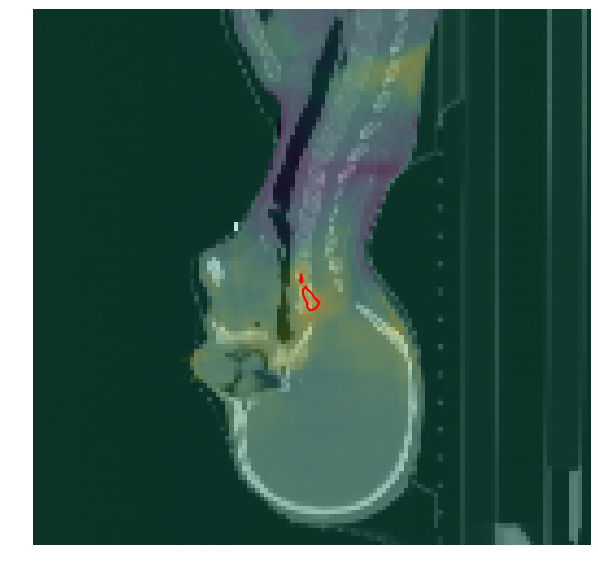

In [95]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

# First show the CT
ctImg = ax.imshow(referenceAnatomy[:,:,64], cmap='Greys_r')

# Now add the t-map with some transparency
rhomapImg = ax.imshow(rhoMap[:,:,64], alpha=0.3)

plt.axis('off');

neg_p005 = np.percentile(threshNeg, 0.05)
neg_p010 = np.percentile(threshNeg, 0.10)
neg_p015 = np.percentile(threshNeg, 0.15) ## Contour plot needs two levels, so we use p=0.05 & 0.10
pos_p005 = np.percentile(threshPos, 0.95)
pos_p010 = np.percentile(threshPos, 0.9)
pos_p015 = np.percentile(threshPos, 0.75)

## Now do the contourplot at the 95% level for p=0.05
pos_contourplot = plt.contour(rhoMap[:,:,64], levels=[pos_p015, pos_p010, pos_p005], colors='r')
# neg_contourplot = plt.contour(rhoMap[:,:,64], levels=[neg_p005, neg_p010, neg_p015], colors='g')

Now we have a complete pipeline to do image based data mining!

Now use this pipeline to try mining against some of the other outcomes in the clinical data, for example:

- Change in BMI between pre/post treatment
- Change in skeletal muscle pre/post treatment
- Change in other areas, e.g. fats
- Skeletal muscle change against CT image density

Have fun!